# Trabalho Prático: Implementação de um Coletor Web

Integrantes: Guilherme Botelho
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ígor Chagas</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lucas Corrêa</p>

Orientador: Daniel Hasan Dalip

## Objetivo

O projeto proposto pelo professor tem como base a implementação de um coletor simples para Web, com o objetivo de estudar e aprender sua arquitetura. O coletor tem que obedecer, obrigatoriamente, os protocolos de exclusão de robôs:
- Critérios pertencentes no robots.txt;
- Critérios "noindex" e "nofollow" das metatags de cada html extraído;
- Obedecer o prazo de, no mínimo, 30 segundos entre requisições em um mesmo servidor;

Os parâmetros utilizados no trabalho, foram:
- Número máximo de páginas: 50.000 páginas
- Profundidade por domínio: 6  páginas
- Número de threads utilizado: 

## Sobre
Nosso coletor recebeu como nome *ri2020g3bot* e mais informações sobre ele podem ser entrcontradas em: https://daegonny.github.io/ri-tp1/

## URLs sementes utilizadas

Para realizar a coleta as urls de sementes utilizadas foram:

In [2]:
import pandas as pd

pd.read_csv('crawler/seeds.txt', header=None, names=['url'])

,url
0,http://cnn.com
1,http://www.gq.com.au/
2,https://www.huffpost.com/
3,http://www.globo.com/
4,https://pt.wikipedia.org/wiki/Wikip%C3%A9dia:P...
5,https://globoesporte.globo.com/
6,https://www.espn.com.br/
7,https://www.foxnews.com/
8,https://www.bbc.com/
9,https://www.reddit.com/


## Principais desafios

Os principais desafios encontrados para a realização do coletor foram relacionados a otimização do tempo de processamento e o uso de recursos compartilhados pelos processos (threads). A programação paralela traz sempre complexidades inerentes ao problema.

Percebemos durante a implementação que a relação entre o tempo de espera, número de processos em paralelo e número de URLs sementes era primordial para o desempenho do coletor. Tendo em vista esse desafio, auxiliados pelo roteiro do projeto, tomamos decisões de implementação que buscassem separar bem os recursos que deveriam ser compartilhados e sincronizados dos que poderiam ser de acesso exclusivo aos _fetchers_. Mais detalhes da implementação são dados a seguir. 

## Decisões e arquitetura utilizada

Para o desenvolvimento do coletor foram implementadas algumas funcionalidades no intuito de resolver os problema comentados anteriormente, buscando a qualidade e perfomace do coletor. As principais considerações são:

### Classe Domain (Domínio)

A classe domain que é responsável pela estruturação do dominios quais o coletor poderá acessar foi adicionada uma propriedade calculada que é `time_will_be_acessible` que possui a responsabilidade de armazenar o horário qual aquele domínio se tornará acessível novamente para realizar uma nova coleta.

Além de algumas propriedade básicas `accessed_now`, `time_since_last_access`, `is_accessible` que calculam o momento que o domínio foi acessado, o tempo desde o último acesso e se o domínio é acessível, respectivamente.

Alguns métodos built-in de classes Python (`__hash__`, `__eq__`, `__str__`, `__repr__`) foram implementadas para auxiliar nos processos de comparação, criação de dicionário e exibição do objetos
   

### Classe Scheduler (Escalonador)
A classe Scheduler que possui a responsabilidade de orquestrar as coletas. Foram desenvolvidas alguns métodos principais para a execução do processo, entre eles foram:

#### get_next_url
Método para obtenção para da próxima URL, caso exista, a ser coletada. Para isso o seguinte algoritmo foi implementado.

- Para cada domínio presente no coletor é verificado se o mesmo está acessível. 
    - Caso verdadeiro a URL é marcada como acessada, removida do Scheduler e retorna o método retorna URL e sua profundidade atual
- Caso nenhuma URL seja acessível é calculada o menor tempo para o próximo dominio ficar disponível através do método `Domain.time_will_be_acessible` e retorna ao page_fetcher o tempo necessário de espera até que um domínio esteja acessível.

Esse processo é executado até o escalonador não possuir mais domínios a serem acessados ou atingir o número desejado de páginas coletadas.

#### add_new_page
Método que adiciona uma nova página ao escalonador desde que atenda aos seguintes critérios:
- Profundidade máxima do domínio ainda não foi atingida
- URL ainda não foi descoberta

Com os critérios atingidos essa função adiciona o URL ao dicionário de domínios.

#### get_robots
Método que com auxílio do robotparser da biblioteca urllib faz download e parsing do arquivo robots de um domínio.

#### can_fetch_page
Com auxílio de um dicionário de e do resultado dos arquivos robots verifica se uma página pode ser coletada.
Optamos por armazenar apenas o booleano no dicionário ao invés do objeto buscando melhorar a performance de acesso.
Mas caso fosse do interesse usar mais informações do arquivo robots seria ideal guardar o objeto inteiro.


#### has_finished_crawl
Método que verifica se os critérios de parada do escalonador foram atingidos.


### Classe Page Fetcher
Classe que irá realizar as ações de coletas dos páginas. Esse classe será executada em paralelo, portanto ela irá herdar da classe Thread do Python.

Os principais métodos para execução dessa classe são:

#### request_url
Dada uma URL retorna o conteúdo binário da página caso esteja bem formatada

#### discover_links
retorna as URLs filhas encontradas no content de uma página.
- Caso seja do mesmo domínio, soma-se 1 na profundidade
- Caso contrário seta como zero a profundidade

#### crawl_new_url
Realiza a coleta da nova URL vinda do metodo `Scheduler.get_next_url` e com base nela é realizado o seguinte fluxo: 

- Se nenhum domínio estiver disponível, aguarda liberação
- Caso nenhuma URL seja retornada a coleta é encerrada pois significa que o dicionário de URLs do escalonador está vazio
- Verifica se a coleta já acabou
- Verifica se a página pode ser acessada
- Caso a coleta não tenha sido encerrada e a página pode ser acessada, ela é requisitada e são checados os seguintes critérios:
 - Se a pagina permite indexação, atraves do método (`has_no_index`),  se sim a URL é armazenada (`collect`)
 - Se a página permite seguir os links, através do método (`has_no_follow`), se sim os links são descobertos e adicionados a fila do escalonador (`gather_links`).

#### has_no_index
Realiza a verificação do tag meta `noindex` na pagina HTML obitida

#### has_no_follow
Realiza a verificação do tag meta `nofollow` na pagina HTML obitida

#### gather_links
A partir da página HTML acessada é feito a procura por `tags a` e descoberta a URL absoluta dos mesmos e qual será a profundidade do link encontrado.

A partir disso é adicionado ao escalonador o link com sua profundidade.

#### collect
O método `collect` adiciona o a URL requisitada a lista de URLs encontradas.

### URLs Coletadas
Utilizando 50 threads, profundidade 6 e a lista de URLs sementes foram coletadas 6.400 URLs. _A priori_ tínhamos por objetivo coletar 50.000, contudo, devido a problemas técnicos de tempo de coleta e requisições não conseguimos cumprir esse objetivo. Entre os problemas encontrados estão o fato de que apesar de aumentar o número de threads o python não estava alocando mais de um núcleo da cpu para executar o coletor e a grande disputa por recursos sincronizados que ocasionavem condições de corrida. 

Uma possibilidade pensada tardiamente seria dividir as urls sementes em mais de um arquivo e inicializar vários processos coletores de forma a ocupar mais núcleos, mas não pôde ser testada em prática.

As URLs coletadas podem ser acessadas no arquivo _*crawler/urls.txt*_.

## Avaliação dos resultados

### Execução do coletor

Abaixo exemplo de execução do coletor com 50 threads, profundidade 6 e objetivo de coletar 50 páginas.

In [2]:
from crawler.report import Report
import pandas as pd

report = Report()

report.run_crawler(int_page_limit=50, int_depth_limit=6, n_threads=50)
pd.read_csv('crawler/urls.txt', header=None, names=['url'])

Finished with 0:00:49.917409
Writing file! Please wait...


,url
0,http://cnn.com
1,http://www.globo.com/
2,https://globoesporte.globo.com/
3,https://www.bbc.com/
4,https://pt.wikipedia.org/wiki/Wikip%C3%A9dia:P...
...,...
57,http://futpedia.globo.com/
58,http://horoscopo.gshow.globo.com/
59,http://cnn.com/
60,http://globoesporte.globo.com/


### Análise de velocidade

Com o objetivo de realizar uma análise da velocidade do coletor baseado no número de threads foi realizado o seguinte teste:

- Aumento do número de threads de 10 a 110, com o aumento de 20 em 20 threads
- Lista de sementes mostrada acima
- Limite de profundidade: 6
- Número limite de página visitadas: 100
- Intel Core TMi7-3610QM CPU, 2.3GHz, 8 GB de RAM, 64 bits, sistema operacional Elementary OS 0.4 (based on Ubuntu 16.04)

Com isso pode-se observar o seguinte resultado:

Finished with 0:01:34.357559
Finished with 0:01:24.708695
Finished with 0:03:43.583529
Finished with 0:04:01.716247
Finished with 0:03:45.761395


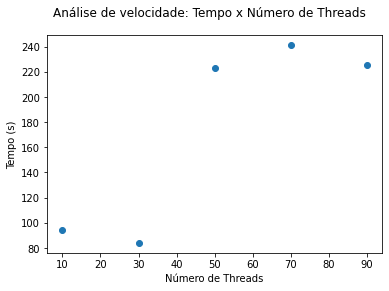

In [1]:
from crawler.report import Report
report = Report()
report.velocity_result(int_page_limit=100, int_depth_limit=6)

Dados os resultados coletados de tempo de execução, podemos observar que aumentar o número de threads quando essas estão executando em um mesmo núcleo aumenta a disputa pelo processador e as chances de condição de corrida na disputa por recursos compartilhados. Houve redução ao aumentar de 10 para 30 threads, porém depois o tempo aumentou.

Outros pontos importantes a se comentar é que um dos fatores que mais impactam no tempo de coleta é o tempo de requisição e resposta das páginas que não são constantes. Portanto cada execução pode haver uma grande diferença de tempo. Além disso é também interessante ser salientado que entre as URLs sementes estão sites de notícia que atualizam constantemente os links que estão nas páginas e ocasionarão em coletas diferentes a cada minuto.